In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
import warnings
warnings.filterwarnings('ignore')

Задание 2. Реализовать жадное решающее дерево.

Создаём нормально распределённый датасет с двумя метками 1, 0, обьединяем в единую структуру данных

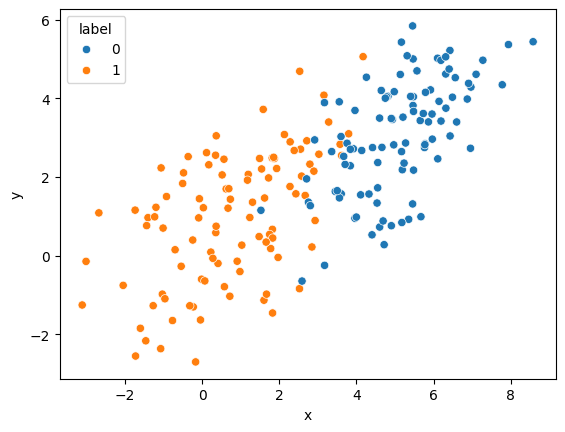

In [14]:
first = pd.DataFrame(np.random.multivariate_normal([1, 1], [[1, 3], [3, 1]], 100), columns=['x', 'y'])
first['label'] = 1
second = pd.DataFrame(np.random.multivariate_normal([5, 3], [[1, 2], [2, 1]], 100), columns=['x', 'y'])
second['label'] = 0

df = pd.concat([first, second]).reset_index(drop=True)

sns.scatterplot(data=df, x='x', y='y', hue='label')
plt.show()


Разбиваем выборку на тестовую и тренировочную, для x и y, обучаем по критерию энтропии. Проверяем точность

In [15]:
X = df[['x', 'y']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Результаты предсказаний:
[1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0
 0 0 1]


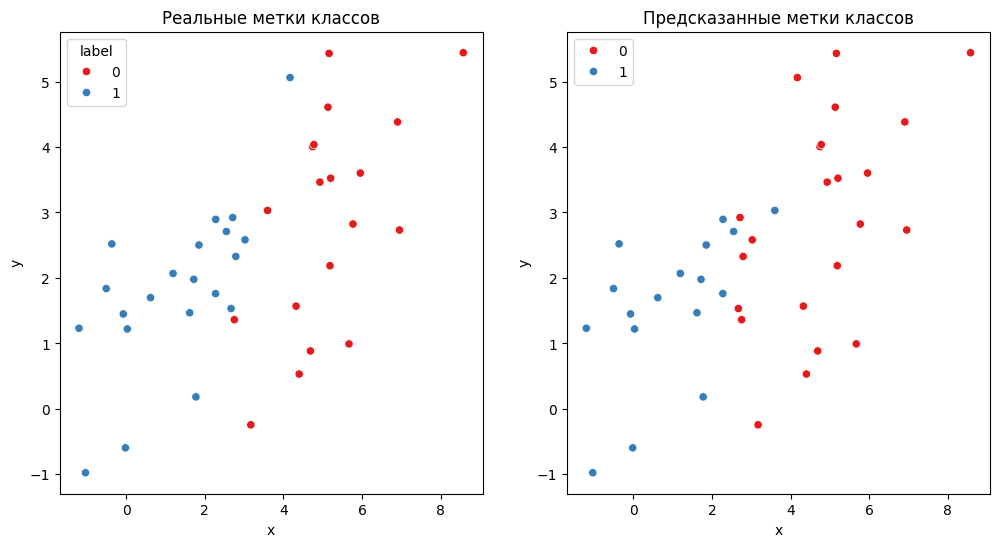

Точность модели: 0.85


In [16]:
decision_tree = DecisionTreeClassifier(criterion='entropy')
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

print("Результаты предсказаний:")
print(y_pred)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=X_test, x='x', y='y', hue=y_test, palette='Set1')
plt.title('Реальные метки классов')

plt.subplot(1, 2, 2)
sns.scatterplot(data=X_test, x='x', y='y', hue=y_pred, palette='Set1')
plt.title('Предсказанные метки классов')

plt.show()

accuracy = accuracy_score(y_test, y_pred)
print(f'Точность модели: {accuracy}')

Создаём новый датасет с большим количеством данных для проверки точности модели

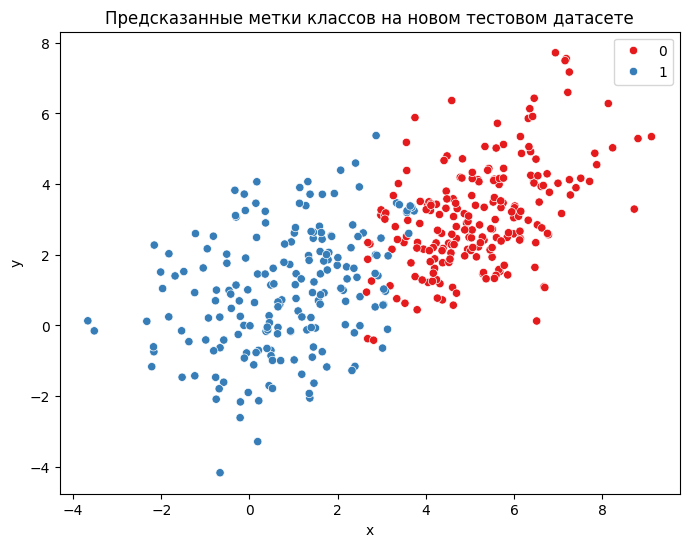

Точность модели на новом тестовом датасете: 0.87


In [17]:
new_first = pd.DataFrame(np.random.multivariate_normal([1, 1], [[1, 3], [3, 1]], 200), columns=['x', 'y'])
new_first['label'] = 1
new_second = pd.DataFrame(np.random.multivariate_normal([5, 3], [[1, 2], [2, 1]], 200), columns=['x', 'y'])
new_second['label'] = 0
new_df = pd.concat([new_first, new_second]).reset_index(drop=True)

new_X = new_df[['x', 'y']]
new_y = new_df['label']

new_y_pred = decision_tree.predict(new_X)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=new_X, x='x', y='y', hue=new_y_pred, palette='Set1')
plt.title('Предсказанные метки классов на новом тестовом датасете')
plt.show()

new_accuracy = accuracy_score(new_y, new_y_pred)
print(f'Точность модели на новом тестовом датасете: {new_accuracy}')


Создаём класс для реализации методов выше, без использования sklearn

In [18]:
class DecisionNode:
    """Узел в решающем дереве."""

    def __init__(self, feature_index=None, threshold=None, left=None, right=None, *, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

def calculate_gini_index(groups, classes):
    """Вычисление индекса Джини для списка групп."""
    n_instances = float(sum([len(group) for group in groups]))
    gini = 0.0
    for group in groups:
        size = float(len(group))
        if size == 0: 
            continue
        score = 0.0
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        gini += (1.0 - score) * (size / n_instances)
    return gini

def test_split(index, value, dataset):
    """Разделение датасета на основе признака и порогового значения."""
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

def get_split(dataset):
    """Получение наилучшего разделения."""
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = calculate_gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index': b_index, 'value': b_value, 'groups': b_groups}

def to_terminal(group):
    """Создание терминального узла."""
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

def split(node, max_depth, min_size, depth):
    """Создание дочерних узлов для узла или преобразование в терминальный узел."""
    left, right = node['groups']
    del(node['groups'])
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

def build_tree(train, max_depth, min_size):
    """Построение решающего дерева."""
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

def predict(node, row):
    """Предсказание с помощью решающего дерева."""
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

# Тестирование решающего дерева на примере датасета
dataset = [[2.771244718,1.784783929,0],
           [1.728571309,1.169761413,0],
           [3.678319846,2.81281357,0],
           [3.961043357,2.61995032,0],
           [2.999208922,2.209014212,0],
           [7.497545867,3.162953546,1],
           [9.00220326,3.339047188,1],
           [7.444542326,0.476683375,1],
           [10.12493903,3.234550982,1],
           [6.642287351,3.319983761,1]]

tree = build_tree(dataset, 3, 1)
for row in dataset:
    prediction = predict(tree, row)
    print('Expected=%d, Got=%d' % (row[-1], prediction))


Expected=0, Got=0
Expected=0, Got=0
Expected=0, Got=0
Expected=0, Got=0
Expected=0, Got=0
Expected=1, Got=1
Expected=1, Got=1
Expected=1, Got=1
Expected=1, Got=1
Expected=1, Got=1


Полученный класс принимает данные в формате списка списков. Используем датасет использованный ранее и приведём его к необходимому виду

In [19]:
# Предполагаем, что df - это наш Pandas DataFrame
# Преобразование DataFrame в список списков
dataset = df.values.tolist()

# Разделение датасета на обучающую и тестовую выборки
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

# Построение решающего дерева на обучающей выборке
tree = build_tree(train, max_depth=3, min_size=1)

# Применение дерева для предсказания классов на тестовой выборке
predictions = [predict(tree, row) for row in test]

# Вычисление точности
actual = [row[-1] for row in test]
accuracy = sum([1 for i in range(len(predictions)) if predictions[i] == actual[i]]) / len(predictions)
print(f'Точность: {accuracy:.2f}')


Точность: 0.88


Визуализируем полученный результат

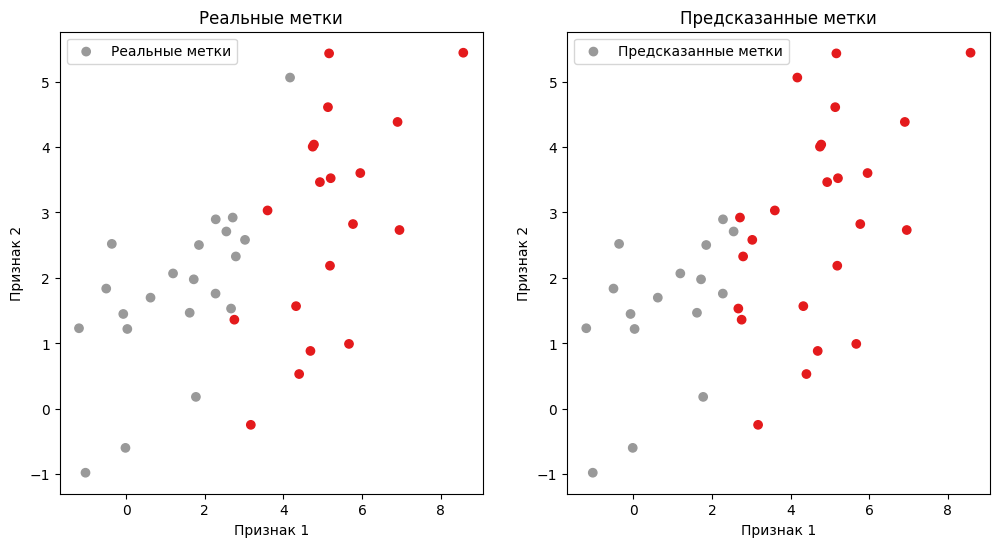

In [20]:
test_data = np.array(test)
x_test = test_data[:, :-1]  # Признаки тестовых данных
y_actual = test_data[:, -1]  # Реальные метки
y_pred = np.array(predictions)  # Предсказанные метки

# Визуализация реальных меток
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_actual, cmap='Set1', label='Реальные метки')
plt.title('Реальные метки')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.legend()

# Визуализация предсказанных меток
plt.subplot(1, 2, 2)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_pred, cmap='Set1', label='Предсказанные метки')
plt.title('Предсказанные метки')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.legend()

plt.show()

Задание 3. KNN алгоритм

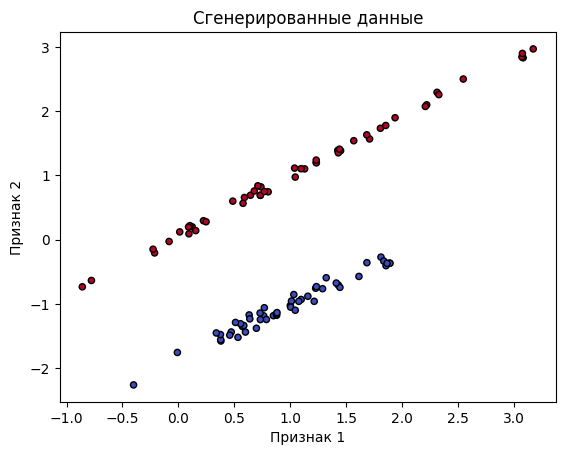

In [21]:
# Генерация синтетических данных
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Визуализация сгенерированных данных
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k', s=20)
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.title('Сгенерированные данные')
plt.show()

Точность: 1.0


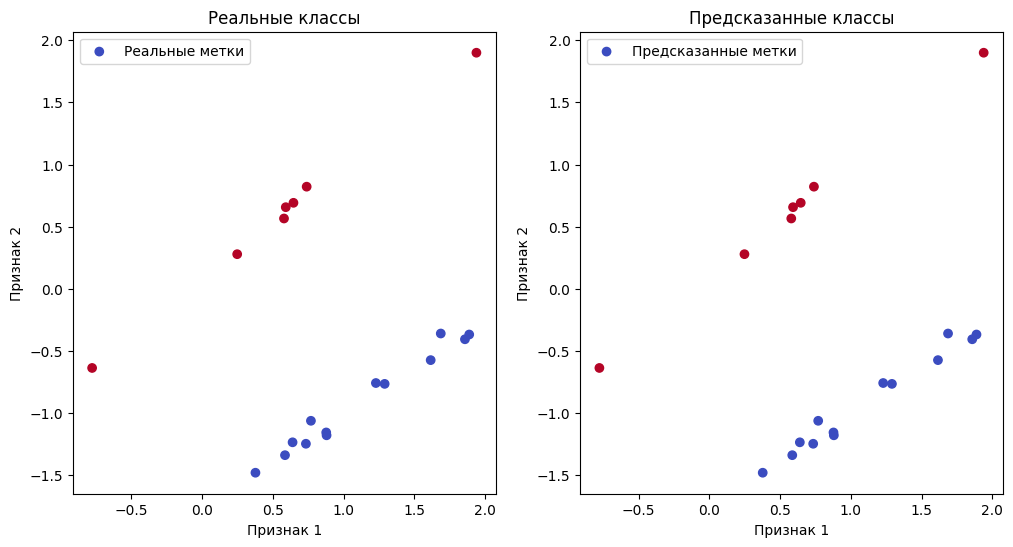

In [22]:
class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        # Вычисление расстояний между x и всеми образцами в обучающем наборе
        distances = [np.sqrt(np.sum((x_train - x) ** 2)) for x_train in self.X_train]
        # Сортировка по расстоянию и возвращение индексов первых k ближайших соседей
        k_indices = np.argsort(distances)[:self.k]
        # Определение классов k ближайших соседей
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        # Определение наиболее распространенного класса среди k ближайших соседей
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

# Создание и обучение KNN модели
clf = KNN(k=3)
clf.fit(X_train, y_train)

# Предсказания на тестовом наборе
predictions = clf.predict(X_test)

# Оценка точности
accuracy = np.mean(predictions == y_test)
print(f"Точность: {accuracy}")

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', label='Реальные метки')
plt.title('Реальные классы')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=predictions, cmap='coolwarm', label='Предсказанные метки')
plt.title('Предсказанные классы')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.legend()

plt.show()

Сделаем датасет сложнее

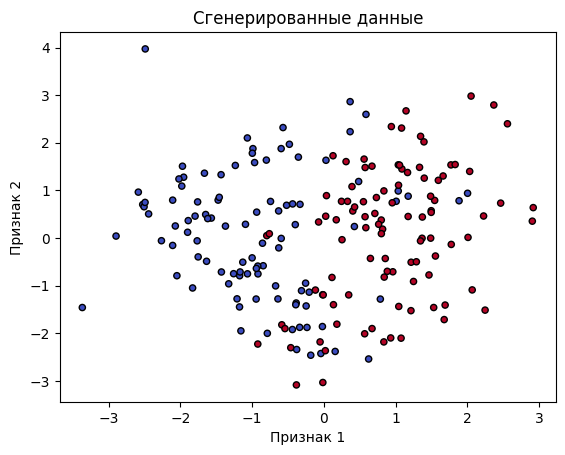

In [23]:
# Генерация более сложных данных
X, y = make_classification(n_samples=200, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Визуализация сгенерированных данных
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k', s=20)
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.title('Сгенерированные данные')
plt.show()

Точность: 0.85


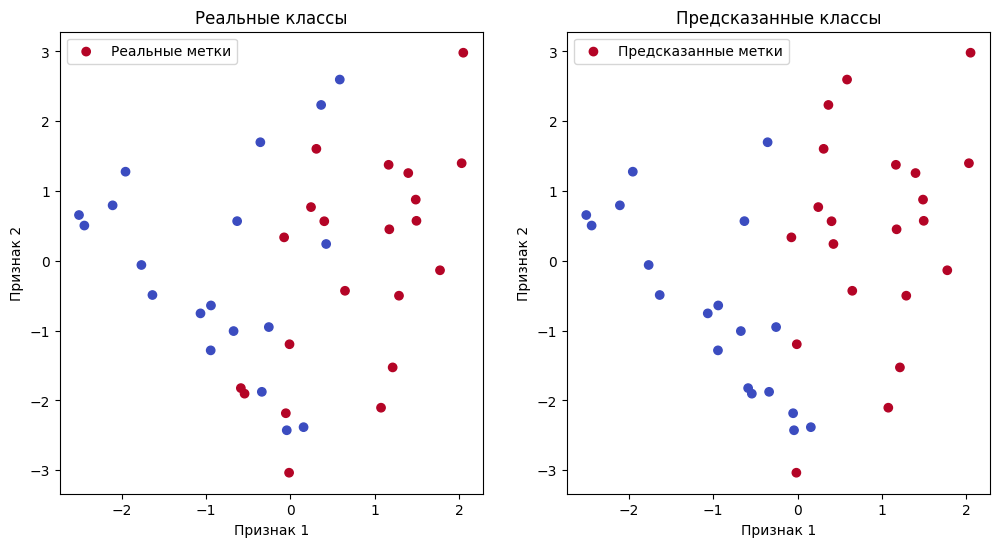

In [24]:
# Создание и обучение KNN модели
clf = KNN(k=3)
clf.fit(X_train, y_train)

# Предсказания на тестовом наборе
predictions = clf.predict(X_test)

# Оценка точности
accuracy = np.mean(predictions == y_test)
print(f"Точность: {accuracy}")

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', label='Реальные метки')
plt.title('Реальные классы')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=predictions, cmap='coolwarm', label='Предсказанные метки')
plt.title('Предсказанные классы')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.legend()

plt.show()